<a href="https://colab.research.google.com/github/Ignas12345/Magistro_projektas/blob/main/knygutes/ketvirtas_bandymas_klasifikuoti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
# uzkraunam neapdorotus duomenis
url = 'https://raw.githubusercontent.com/Ignas12345/Magistro_projektas/refs/heads/main/counts_combined.csv'
df = pd.read_csv(url)
full_gene_names = df["miRNA_ID"].to_numpy()
df_trimmed = df.drop(df.columns[0], axis=1)
full_data = (df_trimmed.to_numpy(dtype=np.int32))
print(np.shape(full_data))

(1881, 139)


In [3]:

# Papildomas filtravimas, jei reikia
#Calculate the percentage of values less than 100 for each row
min_counts = 1000
max_below_min_counts = 0.98
percent_less_than_100 = np.sum(full_data < min_counts, axis=1) / full_data.shape[1]

# Keep only rows where values less than min_counts occur max_below_min_counts or less of the time
filtered_data = full_data[percent_less_than_100 <= max_below_min_counts]
filtered_gene_names = full_gene_names[percent_less_than_100 <= max_below_min_counts]

# Display the filtered array
print(np.shape(filtered_data))

(300, 139)


In [4]:
X = filtered_data.T
gene_ids = filtered_gene_names
print(np.shape(X))

(139, 300)


In [ ]:
print(X[:5, 105])
print((np.delete(X, 2, axis = 0))[:4, 105])

[87325 48793  9623 40540 78825]
[87325 48793 40540 78825]


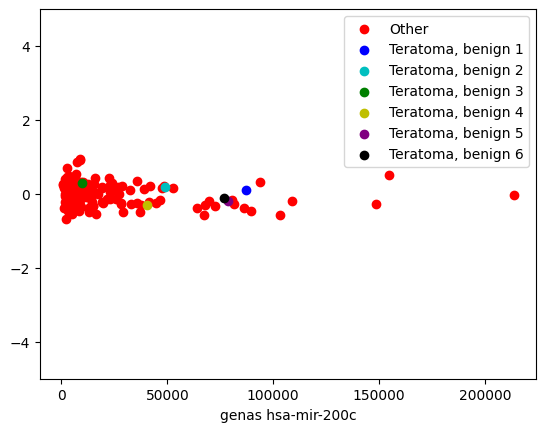

In [5]:
try:
  #i=np.where(gene_ids == 'hsa-mir-520f')[0][0]
  i = 105


  plt.scatter(X[6:139, i], np.random.normal(scale=0.3, size = len(X[6:139, 0])), c = 'r', label = 'Other')
  plt.scatter(X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
  plt.scatter(X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
  plt.scatter(X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
  plt.scatter(X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
  plt.scatter(X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
  plt.scatter(X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
  plt.xlabel('genas ' + str(gene_ids[i]))
  plt.ylim(-5, 5)
  plt.legend()
  plt.show()
except:
    print('Sitas genas isfiltruotas - reiktu pakeisti X matrica')

In [108]:
num_samples = X.shape[0]
labels = torch.zeros(num_samples, dtype=torch.float32)
labels[6:] = 1

features = torch.tensor(X, dtype=torch.float32)
mean_X = features.mean(dim=0)
std_X = features.std(dim=0)
transformed_X = (X - mean_X.numpy()) / (std_X.numpy() + 1e-8)

In [114]:
print(transformed_X[:, 25])

[ 1.85632632e+00  1.70072551e+00 -6.63542312e-01  1.07400004e+00
  2.78707023e-01  2.94120973e+00 -4.08529878e-01 -6.50575578e-01
 -5.29552728e-01 -7.41342716e-01  3.82440894e-01  3.23390772e-02
 -3.22084984e-01 -4.12852122e-01 -4.69041303e-01 -2.87507027e-01
 -2.39962336e-01 -2.18351113e-01 -3.78274165e-01  5.97542548e+00
 -1.01650507e-01  2.66458607e+00  3.87481458e+00 -5.85741908e-01
 -7.84565163e-01 -5.72775174e-01 -7.45664961e-01 -4.77685792e-01
 -4.99297015e-01  4.25084986e+00 -5.33874973e-01 -4.90652526e-01
 -5.38197217e-01 -5.90064153e-01 -4.25818856e-01  1.55809144e+00
 -5.07941505e-01 -2.83184783e-01 -3.17762740e-01 -3.56662942e-01
  1.67046980e+00 -4.08529878e-01 -2.74540293e-01 -5.72775174e-01
 -6.98120269e-01 -4.25818856e-01 -6.70725498e-02 -7.13947945e-02
  4.81852521e-01 -5.51163951e-01  3.86763139e-01 -2.14028868e-01
 -5.46841706e-01  2.61418044e-01  1.65318082e+00 -4.34463345e-01
 -6.07353132e-01  6.24486595e-01 -5.42519462e-01 -8.43615284e-02
 -4.12852122e-01 -7.11087

In [6]:

#jeigu norim, galim istrinti isskirtini elementa
num_samples = X.shape[0] - 1
features = torch.tensor(np.delete(X, 2, axis = 0), dtype=torch.float32)
labels = torch.zeros(num_samples, dtype=torch.float32)
labels[5:] = 1
# cia baigiasi isskirtinio meginio istrynimas (uzkomentuoti sias elutes jeigu to nenorim)

#netikri papildomi treniravimo duomenys
benign_features = features[np.where(labels == 0)]  # First 6 samples are benign
benign_labels = labels[np.where(labels == 0)]


# Duplicate benign samples with slight noise
for i in range(10):
  augmented_features = benign_features + 0.01 * torch.randn_like(benign_features)
  features = torch.cat([features, augmented_features])
  labels = torch.cat([labels, benign_labels])

features = (features - mean) / (std + 1e-8)

# Combine features and labels into a dataset
dataset = TensorDataset(features, labels)

In [7]:
print(np.shape(features))

torch.Size([188, 300])


In [8]:
test_labels = torch.zeros(139, dtype=torch.float32)
test_labels[6:] = 1
test_features = torch.tensor(X, dtype=torch.float32)
test_features = (test_features - mean) / (std + 1e-8)

In [31]:
from imblearn.over_sampling import RandomOverSampler

#dar padauginam benign meginiu
# Convert data to numpy for resampling
features_np = features.numpy()
labels_np = labels.numpy()

# Oversample
ros = RandomOverSampler()
features_resampled, labels_resampled = ros.fit_resample(features_np, labels_np)

# Convert back to tensors
features = torch.tensor(features_resampled, dtype=torch.float32)
labels = torch.tensor(labels_resampled, dtype=torch.float32)

dataset = TensorDataset(features, labels)

In [9]:
# Create a DataLoader for batching
batch_size = 2  # You can adjust this as needed
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example: Print the shape of a batch
for batch_features, batch_labels in data_loader:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Batch features shape: torch.Size([2, 300])
Batch labels shape: torch.Size([2])


In [32]:
class SparseNN(nn.Module):
    def __init__(self, input_dim, temperature = 1):
        super(SparseNN, self).__init__()
        self.input_dim = input_dim
        self.temperature = temperature
        self.first_layer_biases = nn.Parameter(torch.randn(input_dim))
        self.output_weights = nn.Parameter(torch.randn(input_dim))  # Raw weights

    def forward(self, x):

        first_layer_output = torch.tanh((x + self.first_layer_biases))
        weighted_output = first_layer_output * self.output_weights
        pooled_output = weighted_output.sum(dim=1)

        output = torch.sigmoid(pooled_output / self.temperature)

        return output

def l1_regularization(weight, lambda_l1=0.001):
    return lambda_l1 * weight.abs().sum()



In [66]:
#initialize the model
input_dim = features.shape[1]
model = SparseNN(input_dim, temperature = 1)
lambda_l1 = 0.01

# Define a loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # L1 sparsity via weight_decay

In [67]:
# Training Loop
num_epochs = 50  # Adjust based on dataset size and convergence

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_features, batch_labels in data_loader:
        # Forward pass
        outputs = model(batch_features)  # Ensure shape compatibility for BCELoss
        # Compute binary cross-entropy loss
        loss = criterion(outputs, batch_labels)

        # Add L1 regularization for sparsity
        loss += l1_regularization(model.output_weights, lambda_l1)

        #make probabilities less extreme
        #penalty = (outputs * torch.log(outputs + 1e-8) + (1 - outputs) * torch.log(1 - outputs + 1e-8)).mean()
        #loss += 0.1 * penalty

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Logging epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}")

# Evaluation (after training)
model.eval()
with torch.no_grad():
    predictions = model(features)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

    # Compute accuracy
    accuracy = accuracy_score(labels.numpy(), predictions.numpy())
    print(f"Training Accuracy: {accuracy:.4f}")

    # Forward pass on the entire dataset
    predictions = model(test_features)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

    # Compute accuracy
    accuracy = accuracy_score(test_labels.numpy(), predictions.numpy())
    print(f"Accuracy over original data set: {accuracy:.4f}")

Epoch [1/50], Loss: 5.0231
Epoch [2/50], Loss: 4.0167
Epoch [3/50], Loss: 3.5785
Epoch [4/50], Loss: 3.2626
Epoch [5/50], Loss: 3.0315
Epoch [6/50], Loss: 2.8684
Epoch [7/50], Loss: 2.7481
Epoch [8/50], Loss: 2.6487
Epoch [9/50], Loss: 2.5834
Epoch [10/50], Loss: 2.5114
Epoch [11/50], Loss: 2.4646
Epoch [12/50], Loss: 2.4160
Epoch [13/50], Loss: 2.3779
Epoch [14/50], Loss: 2.3283
Epoch [15/50], Loss: 2.2910
Epoch [16/50], Loss: 2.2519
Epoch [17/50], Loss: 2.2186
Epoch [18/50], Loss: 2.1833
Epoch [19/50], Loss: 2.1505
Epoch [20/50], Loss: 2.1228
Epoch [21/50], Loss: 2.0932
Epoch [22/50], Loss: 2.0625
Epoch [23/50], Loss: 2.0322
Epoch [24/50], Loss: 2.0017
Epoch [25/50], Loss: 1.9733
Epoch [26/50], Loss: 1.9443
Epoch [27/50], Loss: 1.9125
Epoch [28/50], Loss: 1.8813
Epoch [29/50], Loss: 1.8550
Epoch [30/50], Loss: 1.8238
Epoch [31/50], Loss: 1.7920
Epoch [32/50], Loss: 1.7610
Epoch [33/50], Loss: 1.7283
Epoch [34/50], Loss: 1.6963
Epoch [35/50], Loss: 1.6655
Epoch [36/50], Loss: 1.6315
E

In [68]:

probs = 100 * model(test_features).detach().numpy()
formatted_probs = np.array([f"{p:.2f}%" for p in probs])
print(formatted_probs)


['0.94%' '2.17%' '100.00%' '3.38%' '1.25%' '1.48%' '100.00%' '100.00%'
 '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%'
 '100.00%' '99.90%' '99.99%' '99.99%' '93.09%' '100.00%' '83.30%' '98.28%'
 '100.00%' '100.00%' '100.00%' '100.00%' '99.99%' '100.00%' '86.60%'
 '100.00%' '99.91%' '100.00%' '100.00%' '100.00%' '64.32%' '100.00%'
 '99.74%' '100.00%' '100.00%' '94.04%' '100.00%' '99.99%' '100.00%'
 '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '99.98%'
 '100.00%' '100.00%' '94.47%' '99.99%' '100.00%' '100.00%' '100.00%'
 '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '99.99%'
 '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '99.98%' '99.04%'
 '99.96%' '99.95%' '100.00%' '96.09%' '100.00%' '100.00%' '100.00%'
 '80.24%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%'
 '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '98.88%' '99.96%'
 '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%' '100.00%'
 '100.00%' '100.00%' 

In [ ]:
#jeigu procentai sutampa su tikrove, issaugom svorius (ir jeigu jie naudingi...)

torch.save(model.first_layer_weights.data, "first_layer_weights.pt")

# Save the first layer's biases (if present)
torch.save(model.first_layer_biases.data, "first_layer_biases.pt")

# Save the second layer (sparse) weights
torch.save(model.output_weights_raw.data, "output_weights_raw.pt")

In [98]:
# Svoriu analize is idejos turetu parodyti, kurie genai yra svarbiausi priimant sprendima

sorted_indices = torch.argsort(np.abs(model.output_weights.data), descending=True)
values_weights = model.output_weights.data[sorted_indices]
values_biases = model.first_layer_biases.data[sorted_indices]
genes = gene_ids[sorted_indices]
sorted_shifted_biases = std[sorted_indices] * values_biases + mean[sorted_indices]

print('indices of largest weights: ' + str(sorted_indices[:30]))
print('largest sorted weights ' + str(values_weights[:30]))
print('corresponding biases ' + str(sorted_shifted_biases[:30]))
print(values_biases[:30])
print('indices of smallest weights: ' + str(sorted_indices[-30:]))
print('smallest sorted weights ' + str(values_weights[-30:]))
print('corresponding biases ' + str(sorted_shifted_biases[-30:]))
print(gene_ids[115])

indices of largest weights: tensor([178, 201,  60,  81,  57, 139, 192,  32,  29, 244, 286,  59, 287, 298,
        108, 141, 128, 105, 151, 116,  96, 138, 219, 161, 198, 146, 130,  25,
        296, 288])
largest sorted weights tensor([-2.6363, -2.5231,  2.4861, -2.2180, -2.0061, -1.9730,  1.8246, -1.6238,
         1.5831,  1.5383,  1.5252,  1.5145,  1.4989, -1.4906,  1.4841,  1.4826,
         1.4700, -1.4639,  1.4395, -1.4230, -1.3732,  1.3369,  1.3243,  1.2911,
        -1.2797, -1.2568, -1.1915, -1.1751,  1.1122,  1.0867])
corresponding biases tensor([-1.6963e+02,  1.0598e+02,  2.9064e+03,  5.6084e+05, -3.7444e+05,
         3.5125e+00,  4.7640e+02,  4.0973e+04,  1.4957e+03, -1.6443e+04,
         1.9361e+02,  6.8601e+04, -2.8415e+03,  2.1531e+04,  9.8649e+03,
        -4.6924e+02,  5.2266e+03,  2.4257e+04,  5.4054e+04, -2.6467e+03,
         1.0963e+03,  1.4030e+03,  5.3536e+02,  7.8941e+01,  1.8687e+02,
         7.6173e+02,  1.0013e+04,  2.0848e+02,  8.4075e+02, -3.5882e+03])
tensor([-1.

In [89]:
shifted_biases = std * model.first_layer_biases.data + mean
print(shifted_biases[25])

tensor(208.4819)


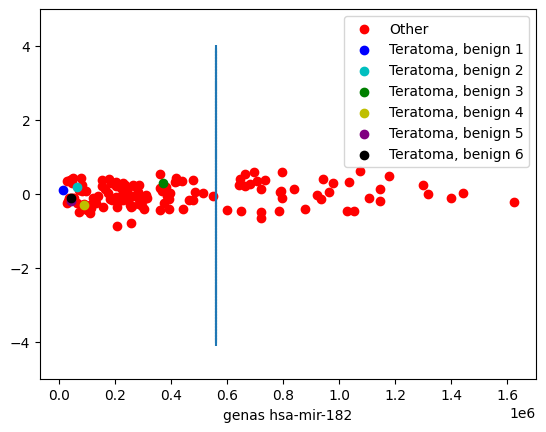

In [119]:
#i=np.where(gene_ids == 'hsa-mir-520f')[0][0]
i = 81


plt.scatter(X[6:139, i], np.random.normal(scale=0.3, size = len(X[6:139, 0])), c = 'r', label = 'Other')
plt.scatter(X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
plt.scatter(X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
plt.scatter(X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
plt.scatter(X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
plt.scatter(X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
plt.scatter(X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
#plt.scatter(np.ones(100) * shifted_biases[i].numpy(), np.arange(start = -4, stop = 4, step = 8 / 100), marker = '|')
plt.xlabel('genas ' + str(gene_ids[i]))
plt.ylim(-5, 5)
plt.legend()
plt.show()

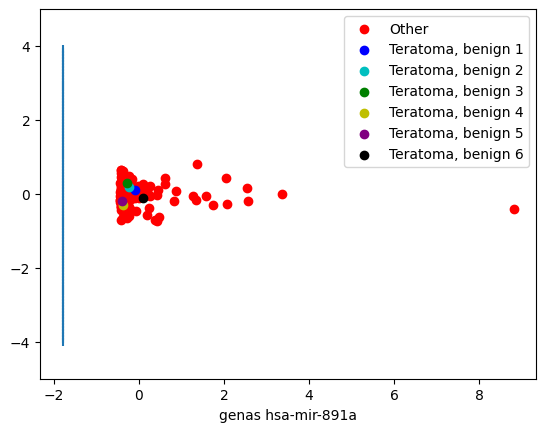

In [117]:
i = 288


plt.scatter(transformed_X[6:139, i], np.random.normal(scale=0.3, size = len(transformed_X[6:139, 0])), c = 'r', label = 'Other')
plt.scatter(transformed_X[0, i], 0.1, c = 'b', label = 'Teratoma, benign 1')
plt.scatter(transformed_X[1, i], 0.2, c = 'c', label = 'Teratoma, benign 2')
plt.scatter(transformed_X[2, i], 0.3, c = 'g', label = 'Teratoma, benign 3')
plt.scatter(transformed_X[3, i], -0.3, c = 'y', label = 'Teratoma, benign 4')
plt.scatter(transformed_X[4, i], -0.2, c = 'purple', label = 'Teratoma, benign 5')
plt.scatter(transformed_X[5, i], -0.1, c = 'k', label = 'Teratoma, benign 6')
#plt.scatter(np.ones(100) * shifted_biases[i].numpy(), np.arange(start = -4, stop = 4, step = 8 / 100), marker = '|')
#plt.scatter(np.ones(100) * model.first_layer_biases.data.numpy()[i], np.arange(start = -4, stop = 4, step = 8 / 100), marker = '|')
plt.xlabel('genas ' + str(gene_ids[i]))
plt.ylim(-5, 5)
plt.legend()
plt.show()

In [107]:
print(torch.mean(features[:,25]))

tensor(0.7288)


In [ ]:
model = SparseNN(input_dim, temperature = 5)

loaded_first_layer_weights = torch.load("first_layer_weights.pt")
loaded_first_layer_biases = torch.load("first_layer_biases.pt")
loaded_otput_weights_raw = torch.load("output_weights_raw.pt")

# Assign the loaded values to the model
model.first_layer_weights.data = loaded_first_layer_weights
model.first_layer_biases.data = loaded_first_layer_biases
model.output_weights_raw.data = loaded_otput_weights_raw

probs = 100 * model(features).detach().numpy()
formatted_probs = np.array([f"{p:.2f}%" for p in probs])
print(formatted_probs)

['0.28%' '2.63%' '98.76%' '13.91%' '6.85%' '2.21%' '100.00%' '99.84%'
 '99.97%' '99.61%' '99.25%' '99.98%' '100.00%' '100.00%' '99.84%' '96.65%'
 '99.59%' '99.98%' '100.00%' '99.96%' '99.95%' '100.00%' '99.56%' '99.91%'
 '99.99%' '100.00%' '99.87%' '98.75%' '99.90%' '91.62%' '99.97%' '99.85%'
 '99.57%' '100.00%' '93.07%' '99.83%' '99.97%' '100.00%' '100.00%'
 '100.00%' '78.69%' '85.09%' '99.97%' '99.86%' '99.94%' '99.91%' '98.92%'
 '96.46%' '100.00%' '99.58%' '100.00%' '98.58%' '99.46%' '99.59%'
 '100.00%' '98.60%' '97.74%' '100.00%' '100.00%' '99.84%' '100.00%'
 '100.00%' '93.83%' '84.41%' '99.85%' '99.96%' '100.00%' '99.79%' '99.79%'
 '99.93%' '99.92%' '92.36%' '100.00%' '99.76%' '99.98%' '99.78%' '99.87%'
 '99.77%' '100.00%' '97.00%' '91.85%' '79.52%' '99.78%' '84.40%' '99.07%'
 '100.00%' '99.98%' '99.56%' '99.98%' '100.00%' '100.00%' '95.92%'
 '99.38%' '92.33%' '99.79%' '100.00%' '99.97%' '99.04%' '100.00%'
 '100.00%' '99.99%' '99.54%' '99.99%' '100.00%' '99.99%' '98.96%' '99.99%'


<ipython-input-84-6c24784f2594>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_first_layer_weights = torch.load("first_layer_weights.pt")
<ipython-input-84-6c24784f